In [13]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import sys

parent_dir = str(Path().resolve().parents[0])
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [14]:
from sklearn.datasets import make_moons, make_classification

from jax import vmap
from functools import partial
import matplotlib.colors as mplcolors

def alpha_scaler(x, T, thresh):
    return (x - thresh) / (np.max(T) - thresh)

@partial(vmap, in_axes=(0, None, None))
def minmax_scaler(x, max_val, min_val):
    return ((x - min_val) / (max_val - min_val)).round(5)

def grey_cmap(alpha):

    rgba = list(mplcolors.to_rgba('grey'))
    rgba[-1] = alpha

    return rgba

# @partial(vmap, in_axes=(0, None))
def rotate_around_origin(pt, angle_in_rad):
    x, y = pt
    c, s = np.cos(angle_in_rad), np.sin(angle_in_rad)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, [x, y])
    return m

def get_super_xlimits(axs, func=max):
    return func([ax.get_xlim() for ax in axs])

def get_super_ylimits(axs, func=max):
    return func([ax.get_ylim() for ax in axs])

In [15]:
n = 500
m = 500

target_rot = -20
source_labels = 0.2
target_labels = 0.9

gamma = 9e-3
gamma_r = 5e-2
gamma_c = 5e-2

num_iters = int(5e4)

colors = np.array(['blue', 'red', 'grey'])

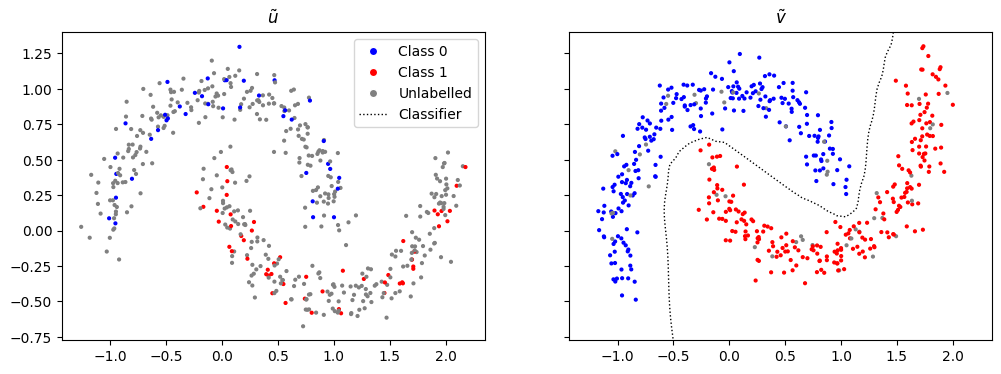

In [16]:
# make source dataset
# X, y = make_classification(n, n_features=2, n_redundant=0, n_informative=2, random_state=1, n_classes=2, n_clusters_per_class=2)
X, y = make_moons(n, noise=0.1, random_state=1)

# perturb labels to have some unknown data
unlabelled_mask = np.where(np.random.random(n) >= source_labels)[0]
y[unlabelled_mask] = 2

# make target dataset
# X_tar, y_tar = make_classification(m, n_features=2, n_redundant=0, n_informative=2, random_state=2, n_classes=2, n_clusters_per_class=1)
X_tar, y_tar = make_moons(m, noise=0.1, random_state=2)
X_tar = np.array([rotate_around_origin(pt, target_rot*np.pi/180) for pt in X_tar]).squeeze()

# perturb labels to have some unknown data
unlabelled_mask = np.where(np.random.random(m) >= target_labels)[0]
y_tar[unlabelled_mask] = 2

# plotting
fig, axs = plt.subplots(1, 2, figsize=(12,4), dpi=100, sharex='all', sharey='all')

axs[0].set_title(r'$\tilde{u}$')
axs[0].scatter(*X.T, color=colors[y], s=4)

axs[1].set_title(r'$\tilde{v}$')
axs[1].scatter(*X_tar.T, color=colors[y_tar], s=4)

# for ax in axs:
#     ax.set_xlim((get_super_xlimits(axs, min)[0], get_super_xlimits(axs, max)[-1]))
#     ax.set_ylim((get_super_ylimits(axs, min)[0], get_super_ylimits(axs, max)[-1]))
    
# classifier boundary
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(12,12),  # one hidden layer with 10 neurons
    activation='tanh',         # smooth nonlinear activation
    solver='lbfgs',            # faster convergence for small datasets
    # alpha=5e-2,                # L2 regularization
    random_state=1,
    max_iter=2000
)
mlp.fit(X_tar[y_tar < 2], y_tar[y_tar < 2]) # only fit on labelled points
xx, yy = np.meshgrid(
    np.linspace(*axs[0].get_xlim(), 50),
    np.linspace(*axs[0].get_ylim(), 50)
)
Z = mlp.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
axs[1].contour(xx, yy, Z, levels=1, colors='k', alpha=1.0, linewidths=1, linestyles='dotted', extend=True)


from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], marker='o', markerfacecolor=colors[0], color='w', label='Class 0'),
                Line2D([0], [0], marker='o', markerfacecolor=colors[1], color='w', label='Class 1'),
                Line2D([0], [0], marker='o', markerfacecolor=colors[2], color='w', label='Unlabelled'),
                Line2D([0], [0], color='k', lw=1, linestyle='dotted', label='Classifier')]
axs[0].legend(handles=custom_lines)

# plot_x = np.linspace(-2, 3)
# axs[0].plot(plot_x, 0.25+0.45*np.sin(3*(plot_x+0.5)), c='k', linestyle='dashed', label='Classifier')
# axs[0].plot(plot_x, 0.25+(0.45+0.1*np.abs(plot_x)**2)*np.sin(3*(plot_x+0.5)), c='k', linestyle='dashed', label='Classifier')
xbounds, ybounds = axs[0].get_xlim(), axs[0].get_ylim()


(500, 2) (500,) (500, 1)
(500, 2) (500,) (1, 500)


 21%|██        | 10254/50000 [00:05<00:20, 1908.32it/s]


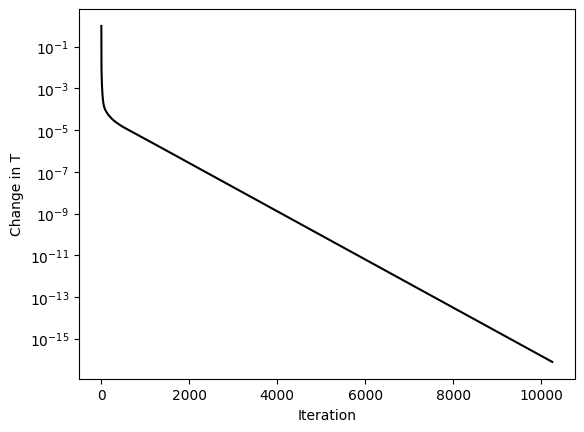

In [17]:
from src.utils.solvers import SoftBregman, LogStabilised_SoftBregman

rows_to_relax = (y == 2).reshape(-1, 1)
cols_to_relax = (y_tar == 2).reshape(1, -1)

l_idxs = np.where(np.logical_and(
    np.tile(y, (m, 1)).T != np.tile(y_tar, (n, 1)),
    np.logical_and(np.tile(y, (m, 1)).T < 2, np.tile(y_tar, (n, 1)) < 2),
))
blocked_idxs = zip(*l_idxs)

mu = np.ones(n)
nu = np.ones(m)

def C(x, y):
    return (np.abs(x - y) ** 2).sum(axis=-1)

print(X.shape, mu.shape, rows_to_relax.shape)
print(X_tar.shape, nu.shape, cols_to_relax.shape)

solver = SoftBregman(gamma, gamma_c, gamma_r, rows_to_relax, cols_to_relax, blocked_idxs)
T = solver.solve(X, X_tar, mu, nu, C=C(X[:, None], X_tar[None, :]), num_iters=num_iters, plot=True, thresh=1e-12)

# # TODO: troubleshoot this log solver, isn't producing valid plans.
# solver = LogStabilised_SoftBregman(gamma, gamma_c, gamma_r, rows_to_relax, cols_to_relax, blocked_idxs)
# # solver.row_exponent_0 = np.ones_like(solver.row_exponent_0)
# # solver.row_exponent_1 = np.zeros_like(solver.row_exponent_1)
# # solver.col_exponent_0 = np.ones_like(solver.col_exponent_0)
# # solver.col_exponent_1 = np.zeros_like(solver.col_exponent_1)

# T = solver.solve(X, X_tar, mu, nu, C=C(X[:, None], X_tar[None, :]), plot=True, num_iters=num_iters)

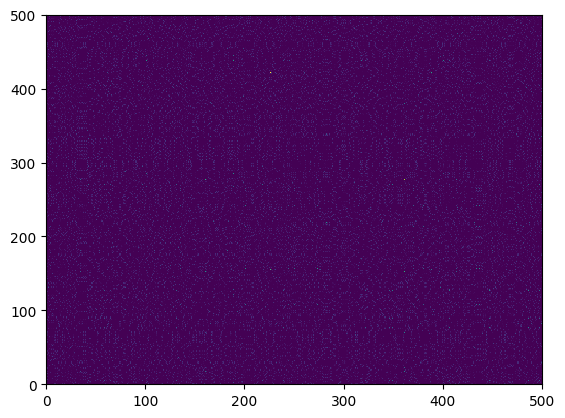

In [18]:
plt.pcolormesh(T)

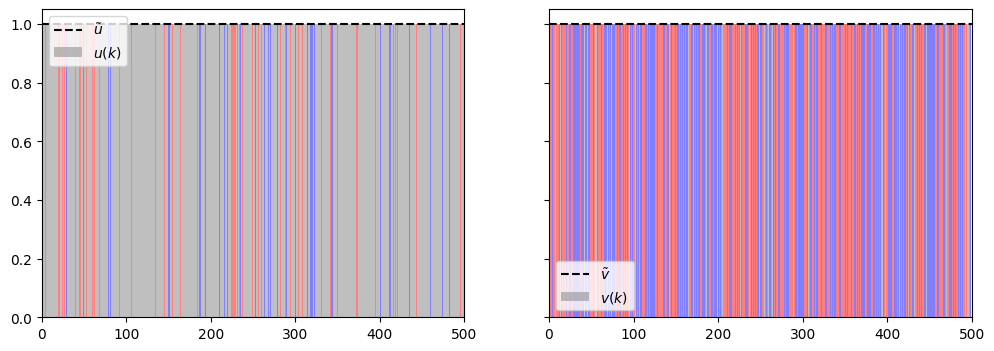

In [19]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey='row')

axs[0].bar(x=range(len(X)), height=np.sum(T, axis=1), width=1, color=colors[y], alpha=0.5, label=r'$u(k)$')
axs[1].bar(x=range(len(X_tar)), height=np.sum(T, axis=0), width=1, color=colors[y_tar], alpha=0.5, label=r'$v(k)$')

axs[0].hlines(y=mu[0], xmin=0, xmax=n, linestyle='dashed', color='k', label=r'$\tilde{u}$')
axs[1].hlines(y=nu[0], xmin=0, xmax=m, linestyle='dashed', color='k', label=r'$\tilde{v}$')

axs[0].set_xlim(0, n)
axs[1].set_xlim(0, m)

axs[0].legend(loc='upper left')
axs[1].legend(loc='lower left')

0.9999999999996305 1.0000000000003724


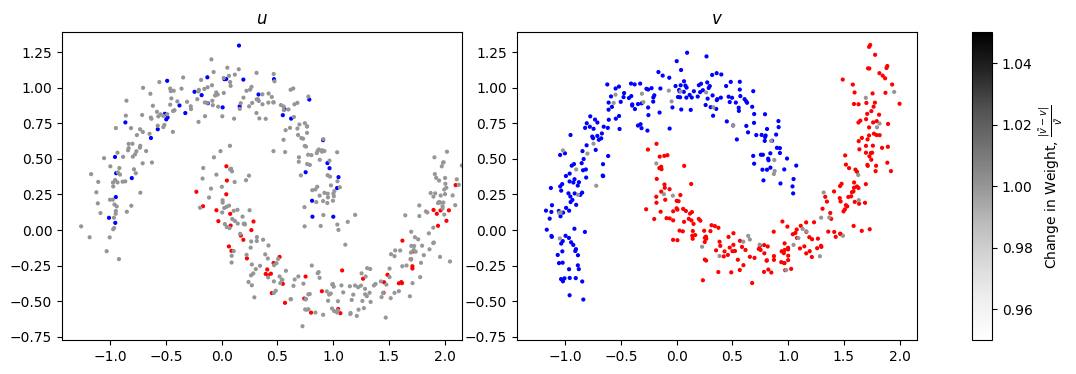

In [20]:
import matplotlib as mpl

weights_0 = np.sum(T, axis=1) / mu
weights_1 = np.sum(T, axis=0) / nu

scale_min, scale_max = np.min([np.min(weights_0), np.min(weights_1)]), np.max([np.max(weights_0), np.max(weights_1)])
print(scale_min, scale_max)
if scale_max - scale_min < 0.1:
    mult = (scale_max - scale_min)
    scale_max += 0.05 - mult
    scale_min -= (0.05 - mult)
# scale_max = max(2.0, scale_max)
# scale_min = min(0.0, scale_min)

cmap = 'Greys'
norm = mplcolors.Normalize(vmin=scale_min, vmax=scale_max)

fig, axs = plt.subplots(1, 3, figsize=(12,4), dpi=100, width_ratios=[1,1,0.05])

axs[0].scatter(*X[y != 2].T, color=colors[y[y != 2]], s=4)
axs[0].scatter(*X[y == 2].T, color=mpl.colormaps[cmap](norm(weights_0[y == 2])), s=4)
axs[0].set_title('$u$')

axs[1].scatter(*X_tar[y_tar != 2].T, color=colors[y_tar[y_tar != 2]], s=4)
axs[1].scatter(*X_tar[y_tar == 2].T, color=mpl.colormaps[cmap](norm(weights_1[y_tar == 2])), s=4)
axs[1].set_title('$v$')

from matplotlib.cm import ScalarMappable
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), cax=axs[-1], label=r'Change in Weight, $\frac{| \tilde{v} - v |}{\tilde{v}}$')

axs = axs[:-1]
for ax in axs:
    ax.set_xlim((get_super_xlimits(axs, min)[0], get_super_xlimits(axs, max)[-1]))
    ax.set_ylim((get_super_ylimits(axs, min)[0], get_super_ylimits(axs, max)[-1]))

# Plans

 - plot v again but with the colour of the space it's transported to

In [21]:
def compute_Xs(X_t, T, labels=None):
    n, m = T.shape
    _, d = X_t.shape
    
    T_sum = np.sum(T, axis=1)
    T_sum[T_sum == 0] = 1e-12
    normalization = T / T_sum[:, None]  # broadcasting over rows
    
    # Finally multiply by X_t
    X_s = normalization @ X_t  # shape (n, d)

    if labels is not None:
        y_s = normalization @ labels
        return X_s, y_s
        
    return X_s

In [22]:
def rgba_interpolate(k, colors, x=2):
    if k == x:
        return colors[1]
    
    elif k < x:
        return (k/x) * colors[1] + (1 - k/x) * colors[0]
    
    else:
        return ((k-x)/x) * colors[2] + (1 - (k-x)/x) * colors[1]

def transport_twoclass_labels(X, T, labels, colors=['blue', 'red', 'grey']):
    labels[labels == 1] = 4 # spread out the classes either side of the neutral label
    colors = colors[[0, 2, 1]] # reorder colors to reflect this
    rgba_colors = mplcolors.to_rgba_array(colors)

    # X_T, y_T = compute_Xs(X, T, labels=labels)
    X_T = T @ X
    y_T = (T / np.sum(T, axis=1, keepdims=True)) @ labels

    colors_T = np.array([rgba_interpolate(y, rgba_colors) for y in y_T])
    colors_T[:, -1] = (norm(np.sum(T, axis=1)))

    return X_T, colors_T


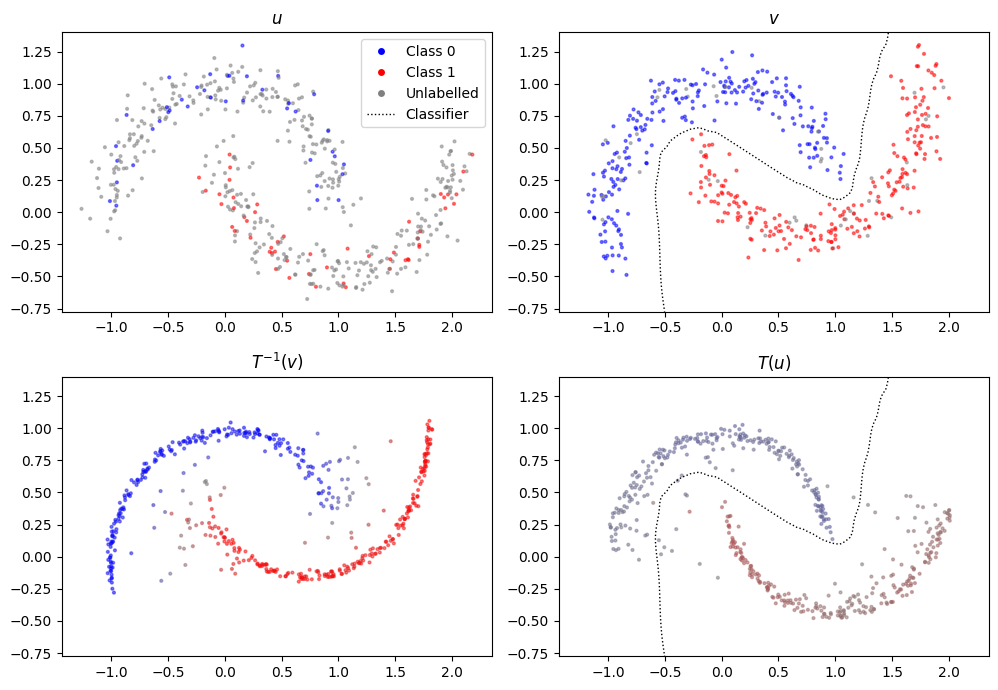

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(10,7), dpi=100)

rgba_colors = mplcolors.to_rgba_array(colors)

# source
colors_s = np.array([rgba_interpolate(label, rgba_colors, x=1) for label in y])
colors_s[:, -1] = (norm(np.sum(T, axis=1)))
axs[0, 0].scatter(*X.T, color=colors_s, s=4)
axs[0, 0].set_title('$u$')

# transported target
X_tar_T, colors_T = transport_twoclass_labels(X_tar, T, y_tar.copy(), colors=colors)
axs[1, 0].scatter(*X_tar_T.T, color=colors_T, s=4)
axs[1, 0].set_title('$T^{-1}(v)$')

# target
colors_tar = np.array([rgba_interpolate(label, rgba_colors, x=1) for label in y_tar])
colors_tar[:, -1] = (norm(np.sum(T, axis=0)))
axs[0, 1].scatter(*X_tar.T, color=colors_tar, s=4)
axs[0, 1].set_title('$v$')

# transported source
X_T, colors_T = transport_twoclass_labels(X, T.T, y.copy(), colors=colors)
axs[1, 1].scatter(*X_T.T, color=colors_T, s=4)
axs[1, 1].set_title('$T(u)$')

fig.tight_layout()

# axs[0,0].set_xlim(-10, 10)
# axs[0,0].set_ylim(-10, 10)
# for ax in axs.flatten():
#     ax.set_xlim((get_super_xlimits(axs.flatten(), min)[0], get_super_xlimits(axs.flatten(), max)[-1]))
#     ax.set_ylim((get_super_ylimits(axs.flatten(), min)[0], get_super_ylimits(axs.flatten(), max)[-1]))

xx, yy = np.meshgrid(
    np.linspace(*axs[0,0].get_xlim(), 50),
    np.linspace(*axs[0,0].get_ylim(), 50)
)
Z = mlp.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
axs[0,1].contour(xx, yy, Z, levels=1, colors='k', alpha=1.0, linewidths=1, linestyles='dotted')
axs[1,1].contour(xx, yy, Z, levels=1, colors='k', alpha=1.0, linewidths=1, linestyles='dotted')

custom_lines = [Line2D([0], [0], marker='o', markerfacecolor=colors[0], color='w', label='Class 0'),
                Line2D([0], [0], marker='o', markerfacecolor=colors[1], color='w', label='Class 1'),
                Line2D([0], [0], marker='o', markerfacecolor=colors[2], color='w', label='Unlabelled'),
                Line2D([0], [0], color='k', lw=1, linestyle='dotted', label='Classifier')]
axs[0,0].legend(handles=custom_lines)

for ax in axs.flatten():
    ax.set_xlim(xbounds)
    ax.set_ylim(ybounds)
# for ax in axs.flatten():
#     ax.grid()
#     ax.set_axisbelow(True)
#     ax.plot(plot_x, 0.25+0.45*np.sin(3*(plot_x+0.5)), c='k', linestyle='dashed', label='Classifier', lw=1)

Text(0.5, 1.0, '$T^{-1}(v)$')

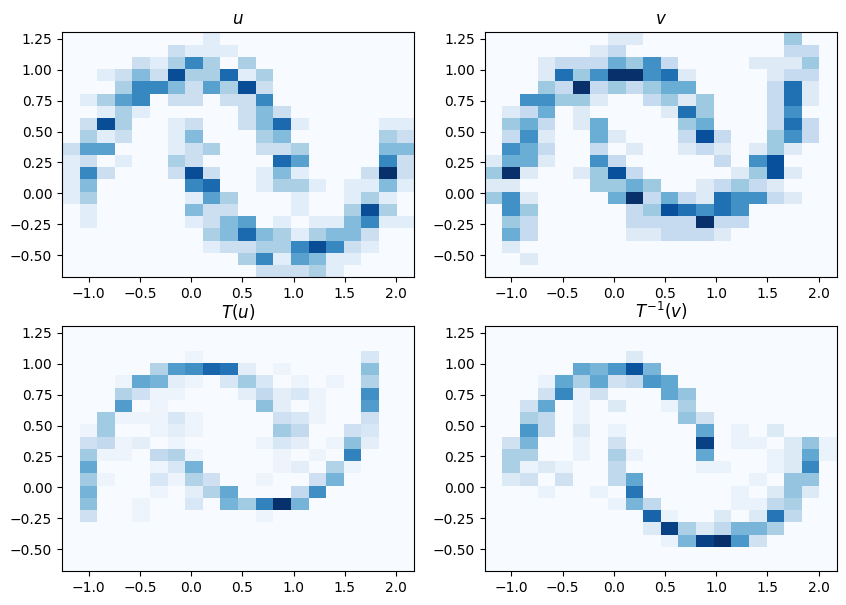

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10,7), dpi=100)

weights, binsx, binsy = np.histogram2d(*np.vstack([X, X_tar]).T, bins=20)

_ = axs[0, 0].hist2d(*X.T, bins=[binsx, binsy], cmap='Blues')
axs[0, 0].set_title('$u$')
_ = axs[0, 1].hist2d(*X_tar.T, bins=[binsx, binsy], cmap='Blues')
axs[0, 1].set_title('$v$')

_ = axs[1, 0].hist2d(*X_tar_T.T, bins=[binsx, binsy], cmap='Blues')
axs[1, 0].set_title('$T(u)$')
_ = axs[1, 1].hist2d(*X_T.T, bins=[binsx, binsy], cmap='Blues')
axs[1, 1].set_title('$T^{-1}(v)$')